### **1.Import thư viện**

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark import SparkContext
SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')

In [3]:
sc = SparkContext(master="local", appName = "Customer segmentation")
sc

<SparkContext master=local appName=Customer segmentation>

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)
spark

In [5]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
# Vẽ Treemap
import matplotlib.pyplot as plt
import squarify
from math import log
import time

### **2. Kiểm tra dữ liệu đầu vào**
- Dữ liệu xử lý đã được xuất ra file df_RFM.csv để huấn luyện cho các dữ liệu mô hình khác nhau.
- Dataset đã được tiền xử lý
- Kiểm tra lại thông tin dữ liệu, xem có lỗi trong quá trình lưu và truy xuất file không  
**comment:** Dữ liệu được load thành công. Không có duplicate, null, đủ điều kiện để thực hiện huấn luyện mô hình.

In [6]:
dataset = spark.read.csv('df_RFM.csv', header=True, inferSchema=True)

In [7]:
dataset.show(3)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         2433|      3|       31|  375.31|
|         2193|     91|       27|  361.45|
|         1793|     26|       25|   345.1|
+-------------+-------+---------+--------+
only showing top 3 rows



In [8]:
dataset.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Monetary: double (nullable = true)



In [9]:
print(len(dataset.columns))
print(dataset.columns)

4
['Member_number', 'Recency', 'Frequency', 'Monetary']


In [10]:
null_counts = dataset.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in dataset.columns])
null_counts_df = null_counts.toPandas()
null_counts_df

,Member_number,Recency,Frequency,Monetary
0,0,0,0,0


**comment:** không có dữ liệu bị thiếu

In [11]:
feat_cols = ["Recency","Frequency","Monetary"]

In [12]:
dataset_selected = dataset.select(feat_cols)
dataset_selected.printSchema()

root
 |-- Recency: integer (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Monetary: double (nullable = true)



In [13]:
if dataset_selected.count() - dataset_selected.dropDuplicates().count() != 0 :
    print("có",dataset_selected.count() - dataset_selected.dropDuplicates().count(),"dữ liệu bị trùng")
else:
    print("không có giá trị trùng trong bộ dữ liệu")

không có giá trị trùng trong bộ dữ liệu


In [14]:
dataset_selected.count()

3898

**comment:** kiểm tra có 3898 dữ liệu

### **3. Model Building**
- Do có độ lệch giữa các giá trị, nên thực hiện chuẩn hóa dữ liệu bằng standard scaler
- Xác định hệ số k dựa trên silhouette score và Elbow Method.

In [15]:
vec_assembler = VectorAssembler(inputCols = feat_cols,outputCol='features')
final_data = vec_assembler.transform(dataset_selected)

In [16]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [17]:
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)

In [18]:
final_data.show(5,truncate=False)

+-------+---------+--------+-------------------+-----------------------------------------------------------+
|Recency|Frequency|Monetary|features           |scaledFeatures                                             |
+-------+---------+--------+-------------------+-----------------------------------------------------------+
|3      |31       |375.31  |[3.0,31.0,375.31]  |[0.01876023743704714,5.8371665700965645,6.7477417756322575]|
|91     |27       |361.45  |[91.0,27.0,361.45] |[0.56906053559043,5.083983786858298,6.498551237116728]     |
|26     |25       |345.1   |[26.0,25.0,345.1]  |[0.16258872445440856,4.7073923952391645,6.204592701422004] |
|4      |29       |334.15  |[4.0,29.0,334.15]  |[0.025013649916062856,5.4605751784774315,6.007721388525535]|
|142    |17       |312.46  |[142.0,17.0,312.46]|[0.8879845720202314,3.201026828762632,5.617754376952533]   |
+-------+---------+--------+-------------------+-----------------------------------------------------------+
only showing top 5 

**comment:** data đã được chuẩn hóa và sẵn sàng cho huấn luyện mô hình

#### Vẽ biểu đồ xem sự thay đổi silhouette score theo k và elbow method để xác định k hợp lý


In [19]:
k_list = []
sse_list = []
silhouette_list = []
sil_str = ""

for k in range(2, 21):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)

    k_list.append(k)

    # SSE (Elbow)
    wssse = model.summary.trainingCost
    sse_list.append(wssse)

    # Silhouette
    predictions = model.transform(final_data)
    evaluator = ClusteringEvaluator(featuresCol='scaledFeatures')
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

    sil_str += f"k = {k} | SSE = {wssse:.2f} | Silhouette = {silhouette:.4f}\n"

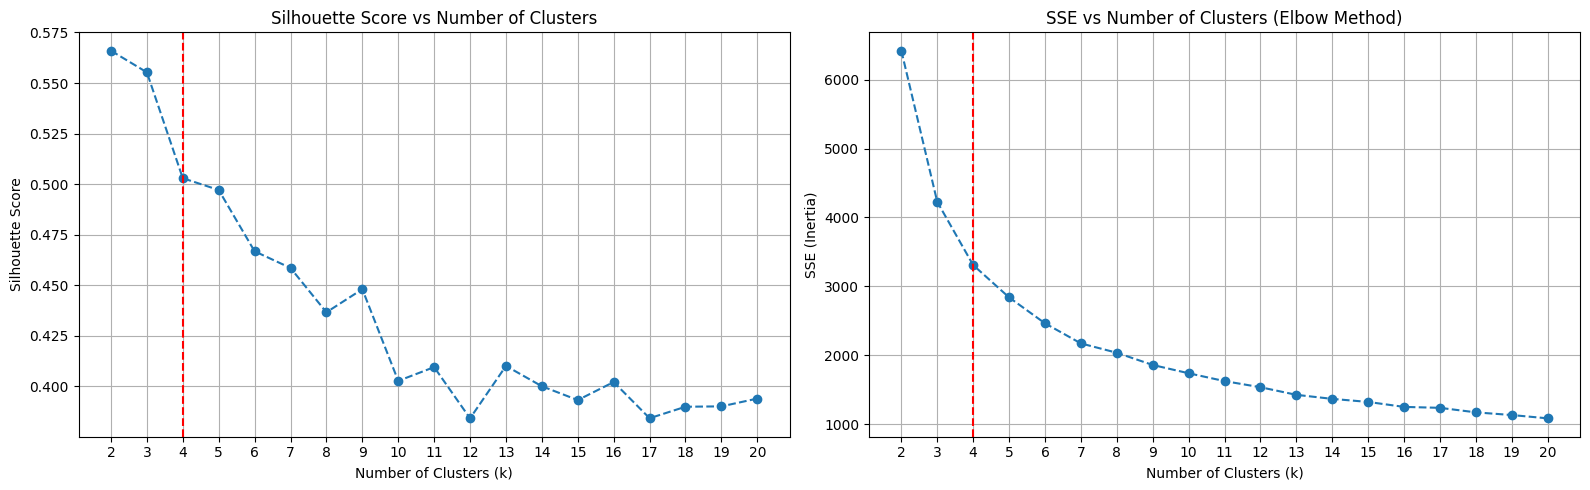

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 hàng, 2 cột

# --- Biểu đồ 1: Silhouette Score ---
axs[0].plot(k_list, silhouette_list, marker='o', linestyle='--')
axs[0].axvline(x=4, color='r', linestyle='--', label='Best k = 4')
axs[0].set_title("Silhouette Score vs Number of Clusters")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Silhouette Score")
axs[0].set_xticks(k_list)
axs[0].grid(True)

# --- Biểu đồ 2: SSE ---
axs[1].plot(k_list, sse_list, marker='o', linestyle='--')
axs[1].axvline(x=4, color='r', linestyle='--', label='Best k = 4')
axs[1].set_title("SSE vs Number of Clusters (Elbow Method)")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("SSE (Inertia)")
axs[1].set_xticks(k_list)
axs[1].grid(True)

plt.tight_layout()
plt.show()

**comment:** 
- dựa trên Elbow graph ta thấy có sự giảm SSE ở k=4 và 5, đồng thời Silhouette Score cho thấy điểm cũng ổn định ở mức k= 4
- Từ đó quyết định chọn k=4

#### **Huấn luyện mô hình với k=4**

In [21]:
start_time = time.time()

In [22]:
kmeans = KMeans(featuresCol='scaledFeatures',k=4)
kmeans_model = kmeans.fit(final_data)

In [23]:
end_time_1 = time.time()

In [24]:
predictions = kmeans_model.transform(final_data)

In [25]:
end_time_2 = time.time()

### **4. Trực quan hóa và đánh giá mô hình**

**1.Tính thời gian huấn luyện và dự đoán của mô hình**

In [27]:
predictions.show(3,False)

+-------+---------+--------+------------------+-----------------------------------------------------------+----------+
|Recency|Frequency|Monetary|features          |scaledFeatures                                             |prediction|
+-------+---------+--------+------------------+-----------------------------------------------------------+----------+
|3      |31       |375.31  |[3.0,31.0,375.31] |[0.01876023743704714,5.8371665700965645,6.7477417756322575]|1         |
|91     |27       |361.45  |[91.0,27.0,361.45]|[0.56906053559043,5.083983786858298,6.498551237116728]     |1         |
|26     |25       |345.1   |[26.0,25.0,345.1] |[0.16258872445440856,4.7073923952391645,6.204592701422004] |1         |
+-------+---------+--------+------------------+-----------------------------------------------------------+----------+
only showing top 3 rows



**comment:** kiểm tra kết quả mô hình được đánh giá - Prediction là kết quả nhóm cluster được phân chia

In [37]:
print ("model training time:", round(end_time_1 - start_time,3),"sec")
print ("Prediction time:", round(end_time_2-end_time_1,3),"sec")

model training time: 2.2 sec
Prediction time: 0.045 sec


**2. Tính hệ số silhouette score:**  
đo độ tách biệt và liên kết nội cụm của các điểm dữ liệu trong phân cụm

In [38]:
#Evaluate clustering by computing Silhouette score
evaluate = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhoutte score: ",round(silhouette,2))

Silhoutte score:  0.5


**comment:**
- giá trị silhoutte score 0.5 cho thấy mô hình được phân cụm tương đối tốt.
- Có thể xem xét thêm các giá trị k lân cận khác để tối ưu mô hình hơn.  

**vd khi chọn k=2,3**  
silhoutte score cao hơn hoàn toàn cho thấy nhưng đạt hiệu quả phân cụm tốt và cao hơn  
Trong khi Elbow lại thể hiện mờ nhạt sự thay đổi  
Thực hiện trực quan hóa, quan sát sự phân cụm của mô hình đã hợp lý chưa.

In [30]:
predictions.createOrReplaceTempView("clustered")

# Thống kê theo cluster
cluster_summary_df = spark.sql("""
    SELECT prediction AS Cluster,
           COUNT(*) AS Count,
           ROUND(AVG(Recency), 1) AS RecencyMean,
           ROUND(AVG(Frequency), 1) AS FrequencyMean,
           ROUND(AVG(Monetary), 1) AS MonetaryMean
    FROM clustered
    GROUP BY prediction
    ORDER BY Cluster
""")
cluster_summary_df.show()

+-------+-----+-----------+-------------+------------+
|Cluster|Count|RecencyMean|FrequencyMean|MonetaryMean|
+-------+-----+-----------+-------------+------------+
|      0| 1291|      125.9|          6.8|        50.8|
|      1|  482|       87.6|         19.3|       189.5|
|      2| 1265|      123.1|         12.7|       108.7|
|      3|  860|      431.7|          5.4|        43.8|
+-------+-----+-----------+-------------+------------+



In [31]:
cluster_summary = cluster_summary_df.toPandas()

In [32]:
# Tính phần trăm
total_customers = cluster_summary['Count'].sum()
cluster_summary['Percent'] = round(100 * cluster_summary['Count'] / total_customers, 2)

# Format tên cụm
cluster_summary['Cluster'] = cluster_summary['Cluster'].apply(lambda x: f'Cluster {x}')

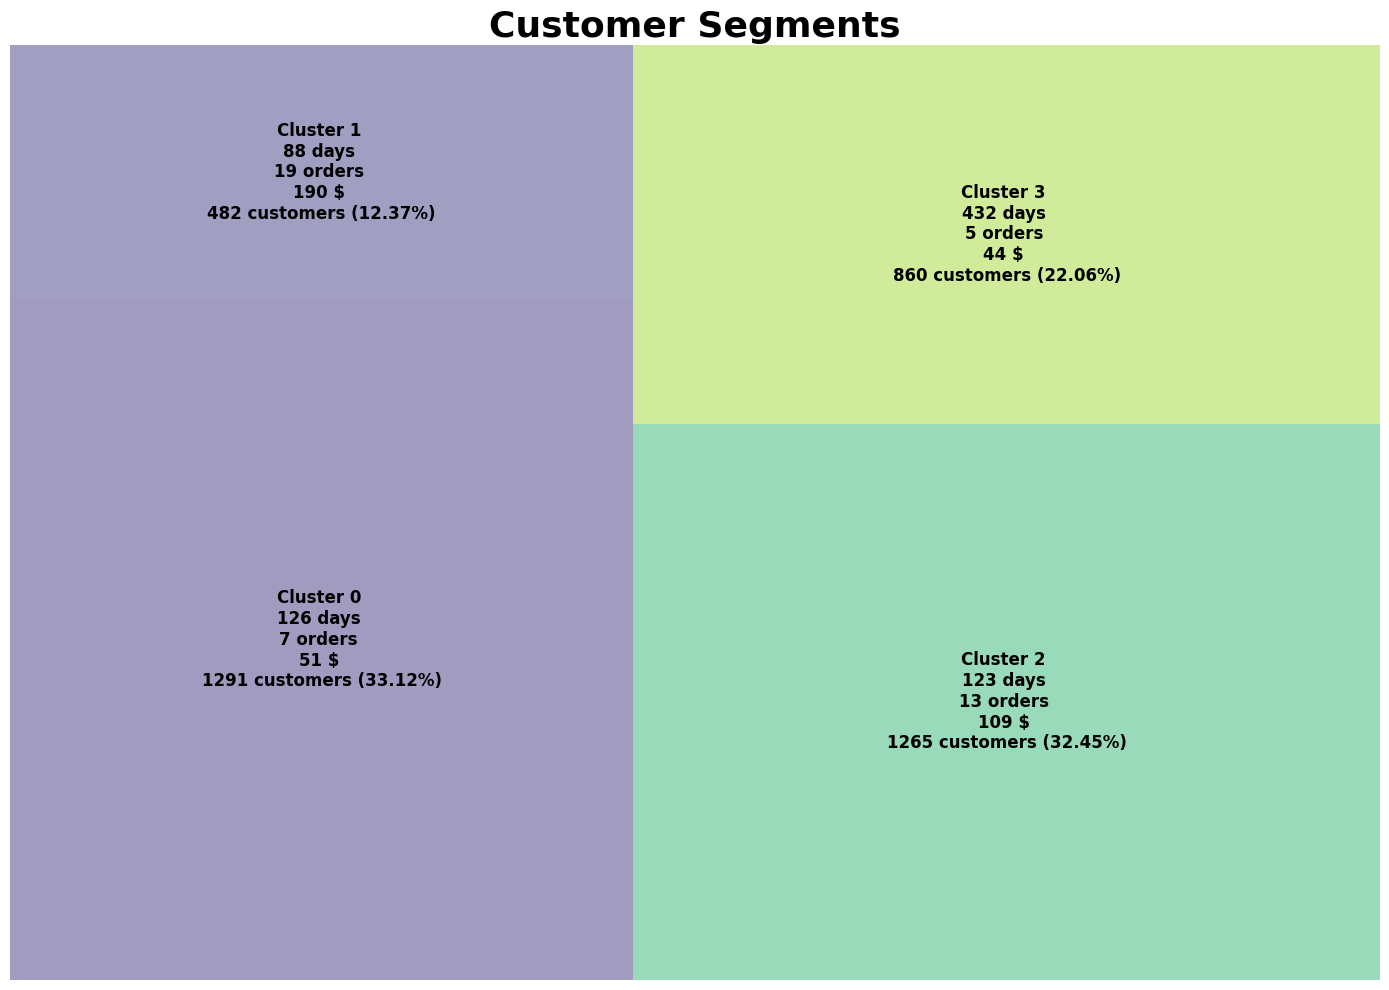

In [34]:
fig = plt.gcf()
fig.set_size_inches(14, 10)
ax = fig.add_subplot()

squarify.plot(
    sizes=cluster_summary['Count'],
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    label=[
        '{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(
            row['Cluster'],
            row['RecencyMean'],
            row['FrequencyMean'],
            row['MonetaryMean'],
            row['Count'],
            row['Percent']
        )
        for _, row in cluster_summary.iterrows()
    ],
    alpha=0.5
)

plt.title("Customer Segments", fontsize=26, fontweight="bold")
plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
cluster_summary

,Cluster,Count,RecencyMean,FrequencyMean,MonetaryMean,Percent
0,Cluster 0,1291,125.9,6.8,50.8,33.12
1,Cluster 1,482,87.6,19.3,189.5,12.37
2,Cluster 2,1265,123.1,12.7,108.7,32.45
3,Cluster 3,860,431.7,5.4,43.8,22.06


**comment:** 
- dựa trên đánh giá các điểm trung tâm của các Cluster, thấy rõ có sự cân bằng trong các nhóm.
- Nhóm 1 R trung bình, F thấp, M thấp
- Nhóm 2 R thấp, F cao,  M cao
- Nhóm 3 R trung bình, F cao, M trung bình
- Nhóm 4 R cao, D thấp, M trung bình

**Trực quan hóa mô hình bằng 3 trục RFM**
- Tính lại các điểm centroids (phục hồi trục)
- Vẽ dữ liệu trên 3 trục và kết hợp thể hiện các điểm centroids tương ứng

In [35]:
# 1. Lấy centroids từ mô hình KMeans
centroids = np.array(kmeans_model.clusterCenters())

# 2. Lấy giá trị std từ scaler_model
std = scaler_model.std.toArray()  # vớiMean=False nên không cần mean

# 3. Inverse transform
centroids_unscaled = centroids * std

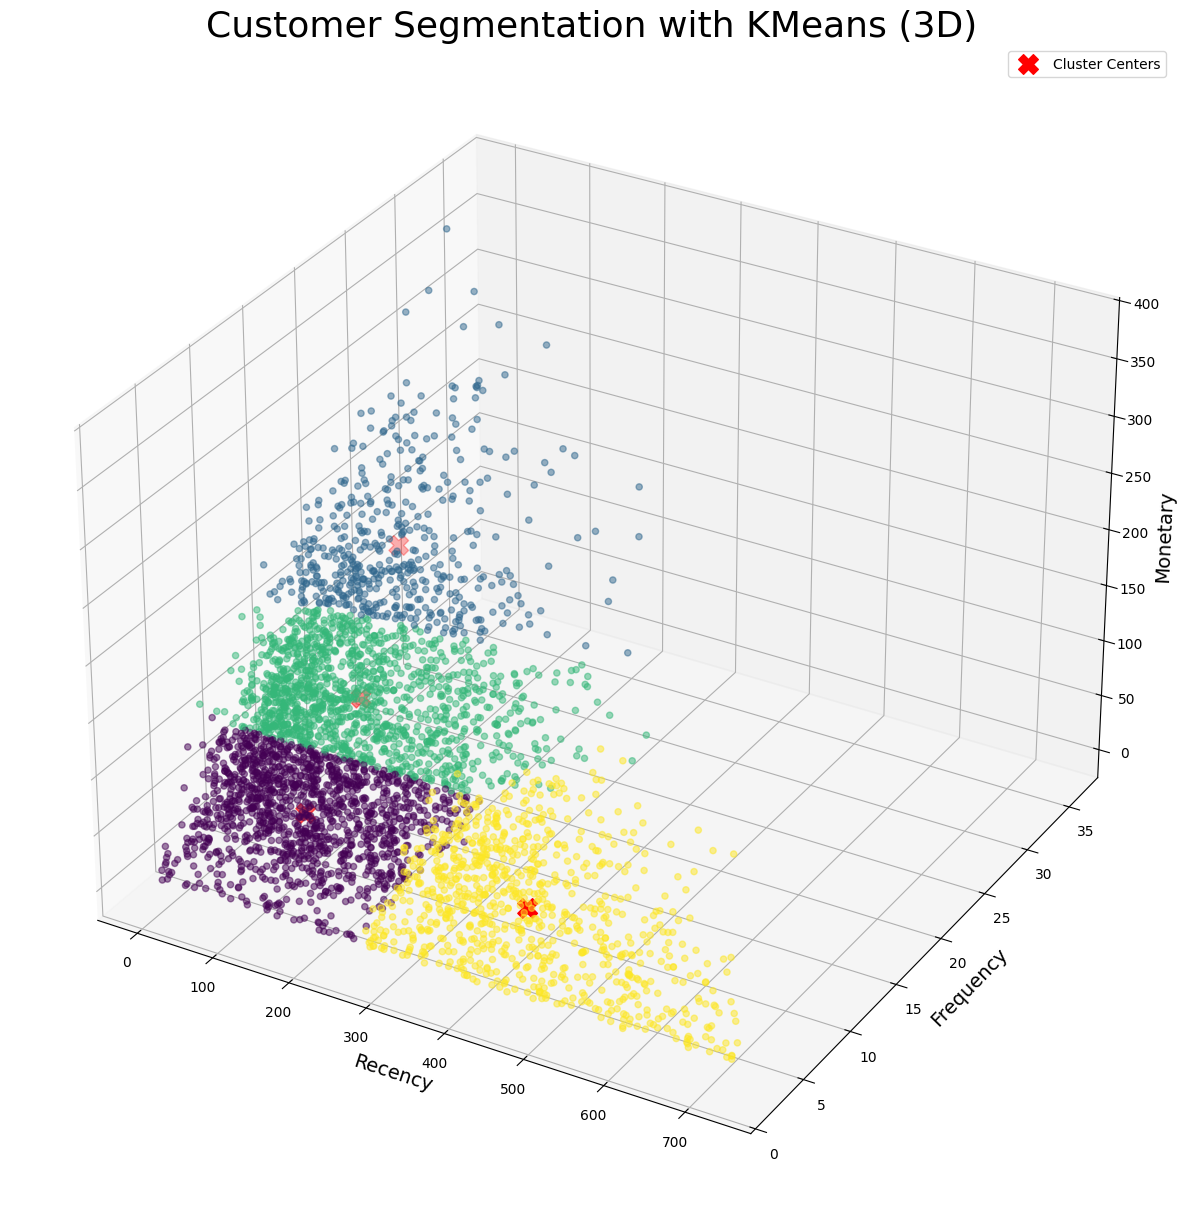

In [36]:
# Trích dữ liệu cụm
df = spark.sql("SELECT Recency, Frequency, Monetary, prediction AS Cluster FROM clustered").toPandas()

# Trích centroid đã hồi scale
centroids = np.array(kmeans_model.clusterCenters())
std = scaler_model.std.toArray()
centroids_unscaled = centroids * std

# Vẽ biểu đồ
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

# Điểm khách hàng
ax.scatter(
    df['Recency'], df['Frequency'], df['Monetary'],
    c=df['Cluster'], cmap='viridis', alpha=0.5
)

# Tâm cụm (đã hồi scale)
ax.scatter(
    centroids_unscaled[:, 0], centroids_unscaled[:, 1], centroids_unscaled[:, 2],
    c='red', s=200, marker='X', label='Cluster Centers'
)

ax.set_xlabel('Recency', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_zlabel('Monetary', fontsize=14)
ax.set_title('Customer Segmentation with KMeans (3D)', fontsize=26)
ax.legend()
plt.show()

**comment:** 
- có sự phân cụm rõ ràng giữa các cụm dữ liệu, cùng với các đặc trưng RFM rõ ràng
- Tùy theo nhu cầu của khách hàng có thể giảm còn mô hình k=3 để đạt hiệu quả phân cụm đơn giản để lên kế hoạch tăng doanh thu cho khách hàng.